<a href="https://colab.research.google.com/github/valentinaborges1/Harnessing-Convolutional-Neural-Networks-for-Accurate-Predicting-Leptospira-Genus-Bacteria-Species/blob/main/Leptospira_Species_Classifier_Genomic_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolutional Neural Network for Accurate Prediction of Leptospira Genus Bacteria Species with Genomic Data**
***Leptospira_Species_Classifier_Genomic_CNN.ipynb***

This code base supports the scientific research:
"**Harnessing Convolutional Neural Networks for Accurate Predicting Leptospira Genus Bacteria Species with Genomic Data**"

---

## **Project Description**

This project implements a Convolutional Neural Network (CNN) for the accurate classification of bacterial species within the *Leptospira* genus, utilizing genomic data. The pipeline encompasses the complete process from data loading and preprocessing (One-Hot Encoding) to CNN model definition, training, and performance evaluation.

## **Authors**

* **Williams Borges**
    * *Affiliation:* Universidad del Zulia, Zulia, Venezuela.
* **Rafael Puche** (Corresponding Author: rpuche@gmail.com)
    * *Affiliation:* Laboratorio de Fisiopatología, Centro de Medicina Experimental, Instituto Venezolano de Investigaciones Científicas, Caracas, Venezuela.
* **Esther Gutiérrez**
    * *Affiliations:*
        * Department of Physics, Faculty of Natural Sciences and Mathematics, Escuela Superior Politécnica del Litoral, P.O. Box 09-01-5863, Guayaquil, Ecuador.
        * Laboratorio de Dinámica Estocástica, Centro de Física, Instituto Venezolano de Investigaciones Científicas, Caracas, Venezuela.

## **Date & Version**
* **Created:** January 05, 2024
* **Modified:** July 24, 2025 (Last Major Revision)
* **Version:** 1.0.0

## **Dependencies**

This project requires Python 3.x and the following libraries. You can install them using `pip` or `conda`:
* **numpy**
* **biopython**
* **scikit-learn**
* **tensorflow**
* **matplotlib**
* **seaborn**
* **pytz**

## **Database**

The genomic data used in this study comprises a carefully curated collection of *Leptospira* species sequences. All selected genomes meet the criteria of being complete, representative, and of high quality, as detailed in the associated publication.

This taxonomically structured database includes reference sequences classified under:
* **Domain:** Bacteria
* **Phylum:** Spirochaetota
* **Class:** Spirochaetes
* **Order:** Spirochaetales
* **Family:** Leptospiraceae
* **Genus:** *Leptospira*

The raw FASTA files used for this project are available in the [data/](https://github.com/yourusername/your_repo/tree/main/data) directory of this repository. Each FASTA file corresponds to a single *Leptospira* species, containing its complete genomic sequences.

**Key Dataset Characteristics & Preprocessing:**

To enable compatibility with the computational model, all nucleotide sequences are transformed using **One-Hot Encoding (OHE)**. Each nucleotide is represented by a numerical vector:
* `A = [1, 0, 0, 0]`
* `C = [0, 1, 0, 0]`
* `G = [0, 0, 1, 0]`
* `T = [0, 0, 0, 1]`

Neural networks require fixed-size input matrices. Therefore, sequences are segmented into fixed lengths. Three different segment sizes were tested: **1500, 3000, and 5000 nucleotides per segment**. A critical consideration for segment size was ensuring it was long enough to potentially include the **16S rRNA gene (approx. 1400-1600 nucleotides)**. This gene's conserved and variable regions are vital for precise taxonomic characterization at various levels, including genus and species differentiation.

Handling of sequences shorter than the selected segment size (e.g., at the end of a genome) involved two strategies:
1.  **Padding with zeros:** Missing values are filled with `0`.
2.  **Truncation/Discarding:** Incomplete segments are discarded.

Both options were evaluated.

The resulting encoded matrices have shapes of **(segment_length, 4)**. The total number of encoded segments is then split into an **80% training set** and a **20% test set**. The data distribution across species is balanced, minimizing bias in model training.

---

In [61]:
# ----------------------------------------------------
# 1. Install Required Libraries (for Google Colab/Jupyter environments)
# This cell ensures all necessary packages are available.
# ----------------------------------------------------
!pip install Biopython
!pip install scikit-learn # Often pre-installed, but good to include for explicit dependency
!pip install tensorflow # Often pre-installed, but good to include for explicit dependency
!pip install matplotlib
!pip install seaborn
!pip install pytz
# Add any other libraries you use that might not be default in Colab
print("\n")
print("All required libraries installed.")



All required libraries installed.


In [78]:
# ----------------------------------------------------
# 2. Library Imports
# This section imports all necessary libraries for data processing,
# model building, training, and visualization.
# ----------------------------------------------------
import os
from google.colab import files
import datetime
import numpy as np
import pytz
from Bio import SeqIO
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, GlobalAveragePooling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.optimizers import SGD, Adam, AdamW
from tensorflow.keras import regularizers
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
print("\n")
print("All libraries imported.")



All libraries imported.


In [63]:
# ----------------------------------------------------
# 2. Upload Genomic Data (FASTA files)
# This cell provides an interface to upload FASTA files directly
# from your local machine to the Google Colab environment.
# Please upload all your Leptospira species FASTA files here
# You can download them from the Database in Github.
# ----------------------------------------------------

# Define the target directory for uploaded data
DATA_DIR = "./database"
os.makedirs(DATA_DIR, exist_ok=True) # Ensure the data directory exists

print("Please upload your FASTA files now. You can select multiple files.")
uploaded = files.upload()

for filename in uploaded.keys():
    # Move the uploaded file to the DATA_DIR
    source_path = os.path.join("/content/", filename)
    destination_path = os.path.join(DATA_DIR, filename)
    os.rename(source_path, destination_path) # Move the file
    print(f"File '{filename}' uploaded and moved to '{DATA_DIR}'")

print("\nAll selected FASTA files have been processed and are ready for analysis.")
print("Proceeding with data loading from the './data' directory...")

Please upload your FASTA files now. You can select multiple files.


Saving Leptospira_alstonii.fasta to Leptospira_alstonii.fasta
Saving Leptospira_biflexa.fasta to Leptospira_biflexa.fasta
Saving Leptospira_interrogans.fasta to Leptospira_interrogans.fasta
Saving Leptospira_kmetyi.fasta to Leptospira_kmetyi.fasta
Saving Leptospira_kobayashii.fasta to Leptospira_kobayashii.fasta
Saving Leptospira_mayottensis.fasta to Leptospira_mayottensis.fasta
Saving Leptospira_santarosai.fasta to Leptospira_santarosai.fasta
File 'Leptospira_alstonii.fasta' uploaded and moved to './database'
File 'Leptospira_biflexa.fasta' uploaded and moved to './database'
File 'Leptospira_interrogans.fasta' uploaded and moved to './database'
File 'Leptospira_kmetyi.fasta' uploaded and moved to './database'
File 'Leptospira_kobayashii.fasta' uploaded and moved to './database'
File 'Leptospira_mayottensis.fasta' uploaded and moved to './database'
File 'Leptospira_santarosai.fasta' uploaded and moved to './database'

All selected FASTA files have been processed and are ready for analy

In [ ]:
# ----------------------------------------------------
# 3. Data Inspection and Summary of FASTA Files
# This cell iterates through the uploaded FASTA files
# to display detailed information about each sequence record.
# ----------------------------------------------------

# Initialize counters for summary
fasta_file_count = 0
unique_record_ids = set()
all_species_sequences = {} # To store sequences per species name (from filename)

print(f"--- Starting detailed inspection of FASTA files in '{DATA_DIR}' ---")

# Iterate through files in the specified data directory
for file_name in os.listdir(DATA_DIR):
    if file_name.endswith(".fasta"):
        fasta_file_count += 1
        # Extract species name from filename (without extension)
        species_name = os.path.splitext(file_name)[0]
        all_species_sequences[species_name] = [] # Initialize list for this species

        print(f"\nProcessing species: {species_name}")
        print("-" * (len(species_name) + 20)) # Visual separator

        file_path = os.path.join(DATA_DIR, file_name)
        try:
            # Parse the FASTA file
            for record in SeqIO.parse(file_path, "fasta"):
                unique_record_ids.add(record.id)
                all_species_sequences[species_name].append(str(record.seq)) # Store for later use

                # Print detailed information for each record
                print(f"  Record ID: {record.id}")
                print(f"  Sequence: {repr(record.seq)}")
                print(f"  Length: {len(record)} nucleotides")
                print("\n")
        except Exception as e:
            print(f"Warning: Could not parse '{file_name}'. Skipping file. Error: {e}")
            # Optionally remove this file from counters if it was problematic
            fasta_file_count -= 1
            if species_name in all_species_sequences:
                del all_species_sequences[species_name]

# Print final summary of inspection
print("--- FASTA File Inspection Complete ---")
print(f"Total FASTA files analyzed: {fasta_file_count}")
print(f"Total unique record IDs found: {len(unique_record_ids)}")
print(f"Summary of sequences by species:")
for species, sequences in all_species_sequences.items():
    print(f"- {species}: {len(sequences)} sequences")

--- Starting detailed inspection of FASTA files in './database' ---

Processing species: Leptospira_kobayashii
-----------------------------------------
  Record ID: AP025028.1
  Sequence: Seq('CCAGATTTTTTTAAATCGGAAGGGGTACTCGAATTTTCATTTGAATTCTACCTA...CAT')
  Length: 3985339 nucleotides


  Record ID: AP025029.1
  Sequence: Seq('ATGTGGTTGAAATTAGGAGAATCCGAAGTCATTAATCTCGATTTTATCGCTTCC...TTT')
  Length: 274191 nucleotides


  Record ID: AP025030.1
  Sequence: Seq('ATGATGCAATTATTCAAATATTTTTCCGCAATTTCCCTTCTTTGTCTTTGTACT...TAA')
  Length: 45413 nucleotides



Processing species: Leptospira_kmetyi
-------------------------------------
  Record ID: accn|CP033614
  Sequence: Seq('ttgtcgaatcctctcgcgttcttttccgatgaaaaaaaggaagaacgattcccg...aat')
  Length: 3927288 nucleotides


  Record ID: accn|CP033615
  Sequence: Seq('ggaaaaaagcgcgagaattccgtctccataaacttatccacaaacccttcgtgt...cgc')
  Length: 489634 nucleotides



Processing species: Leptospira_alstonii
---------------------------------------
  Recor

In [64]:
# ----------------------------------------------------
# 4. Sequence Loading and Grouping by Species
# This section iterates through the FASTA files, extracts
# genomic sequences, and organizes them by species name.
# ----------------------------------------------------

# Initialize dictionary to store sequences grouped by species
species_sequences_dict = {}

print(f"--- Starting sequence extraction from FASTA files in '{DATA_DIR}' ---")

for file_name in os.listdir(DATA_DIR):
    if file_name.endswith(".fasta"):
        # Get species name from filename (without extension)
        species_name = os.path.splitext(file_name)[0]

        # Initialize list for this species if not already present
        if species_name not in species_sequences_dict:
            species_sequences_dict[species_name] = []

        file_path = os.path.join(DATA_DIR, file_name)
        try:
            # Read the FASTA file and extract sequences
            for record in SeqIO.parse(file_path, "fasta"):
                sequence = str(record.seq).lower() # Extract sequence as string
                species_sequences_dict[species_name].append(sequence)
        except Exception as e:
            print(f"Warning: Could not parse '{file_name}'. Skipping its sequences. Error: {e}")

print("\n--- Sequence Extraction Complete ---")
print("Sequences loaded and grouped by species.")
# Optional: Print a summary of loaded sequences per species
for species, seq_list in species_sequences_dict.items():
    print(f"- {species}: {len(seq_list)} sequences")

# 'species_sequences_dict' contains all sequences, grouped by species.


--- Starting sequence extraction from FASTA files in './database' ---

--- Sequence Extraction Complete ---
Sequences loaded and grouped by species.
- Leptospira_kobayashii: 3 sequences
- Leptospira_kmetyi: 2 sequences
- Leptospira_alstonii: 2 sequences
- Leptospira_interrogans: 2 sequences
- Leptospira_biflexa: 3 sequences
- Leptospira_santarosai: 2 sequences
- Leptospira_mayottensis: 3 sequences


In [65]:
# ----------------------------------------------------
# 5. Species Verification and Count
# This cell iterates through the loaded species and confirms
# the total number of unique species identified.
# ----------------------------------------------------

# Assuming 'species_sequences_dict' from the previous cell is available
# (which contains sequences grouped by species name)

print("--- Listing Identified Species ---")
for species_name in species_sequences_dict.keys():
    print(f"- {species_name}") # Print each species name clearly

print('\n') # Add a newline for better visual separation

total_species_count = len(species_sequences_dict.keys())

print(f"Total number of species identified: {total_species_count}")

--- Listing Identified Species ---
- Leptospira_kobayashii
- Leptospira_kmetyi
- Leptospira_alstonii
- Leptospira_interrogans
- Leptospira_biflexa
- Leptospira_santarosai
- Leptospira_mayottensis


Total number of species identified: 7


In [66]:
# ----------------------------------------------------
# 6. One-Hot Encoding Functions
# This section defines two distinct functions for applying
# One-Hot Encoding to DNA sequences, handling variable
# fragment lengths through either zero-padding or discarding.
# ----------------------------------------------------

# One-Hot Encoding with padding zeros
def onehot_encoding_pz(sequence, max_len):
  """
  Applies One-Hot Encoding to a DNA sequence with zero-padding.
  This function encodes a given DNA sequence into a numerical One-Hot
  representation. If the sequence length is less than `max_len`, it
  is padded with zeros to match `max_len`. If the sequence is of equal length
  than `max_len`, it is encoded as is.
  Args:
  sequence (str): The DNA sequence to be encoded.
  max_len (int): The target length for the encoded segment. Shorter sequences will be padded with zeros.
  Returns:
  numpy.ndarray: The One-Hot Encoded sequence, padded to `max_len` if necessary.
  """
  if len(sequence) == max_len:
    encoder = OneHotEncoder()
    encoded_segment = encoder.fit_transform([[nuc] for nuc in sequence]).toarray()
    return encoded_segment
  elif len(sequence)>0:
    encoder = OneHotEncoder()
    encoded_segment = encoder.fit_transform([[nuc] for nuc in sequence]).toarray()
    zeros = np.zeros((max_len - len(sequence), 4))
    encoded_segment = np.concatenate((encoded_segment, zeros))
    return encoded_segment

# One-Hot Encoding with Truncation
# Global counters for discarded fragments
discarded_fragments_count = 0
discarded_fragment_lengths = []

def onehot_encoding_tr(sequence, max_len):
  """
  Applies One-Hot Encoding to a DNA sequence, discarding if it's shorter than max_len.
  This function encodes a given DNA sequence into a numerical One-Hot
  representation. If the sequence's length is less than `max_len`,
  it is discarded, and its length is recorded in a global list.
  Args:
  sequence (str): The DNA sequence to be encoded.
  max_len (int): The required length for the encoded segment.
  Returns:
  numpy.ndarray or None: The One-Hot Encoded sequence if its length matches `max_len`, otherwise returns None.
  """
  global discarded_fragments_count, discarded_fragment_lengths
  if len(sequence) == max_len:
    encoder = OneHotEncoder()
    encoded_segment = encoder.fit_transform([[nuc] for nuc in sequence]).toarray()
    return encoded_segment
  else:
    discarded_fragments_count += 1
    discarded_fragment_lengths.append(len(sequence))
    return None


In [67]:
# ----------------------------------------------------
# 7. Apply One-Hot Encoding and Sequence Fragmentation
# This section iterates through all loaded genomic sequences,
# applies One-Hot Encoding, and fragments them into fixed
# length segments. Short segments are handled according to
# the chosen strategy (Padding or Truncation).
# ----------------------------------------------------
# @markdown **Select the Segment Length for DNA Sequence Fragmentation**
# @markdown
# @markdown This parameter defines the fixed length (number of nucleotides) for segmenting the genomic sequences.
max_len = "5000" #@param [1500, 3000, 5000]
# Transform the selected value to an integer
max_len = int(max_len)

# @markdown **Define the Padding (If isn't check will be Truncation)**
Padding = False # @param {type:"boolean"}

# Initialize a dictionary to store one-hot encoded sequences per species
encoded_sequences = {}

# Process each species and its sequences from the input dictionary
for species_name, sequences_list in species_sequences_dict.items():
    # Initialize a list to hold encoded fragments for the current species
    encoded_sequences[species_name] = []

    # Iterate through each DNA sequence for the current species
    for sequence_str in sequences_list:
        # Convert the entire sequence to lowercase for consistent processing
        sequence_str = sequence_str.lower()

        # Split the sequence into fragments of max_len nucleotides
        for i in range(0, len(sequence_str), max_len):
            fragment = sequence_str[i:i + max_len]

            # Apply one-hot encoding (Padding or Truncation)
            if Padding == True:
              encoded_fragment = onehot_encoding_pz(fragment, max_len)

            if Padding == False:
              encoded_fragment = onehot_encoding_tr(fragment, max_len)

            # Only append the fragment if the encoding was successful (not None)
            if encoded_fragment is not None:
                encoded_sequences[species_name].append(encoded_fragment)

print("One-hot encoding of sequences completed successfully.")
print(f"Total discarded fragments: {discarded_fragments_count}")
print(f"Lengths of discarded segments: \n{discarded_fragment_lengths}")

One-hot encoding of sequences completed successfully.
Total discarded fragments: 17
Lengths of discarded segments: 
[339, 4191, 413, 2288, 4634, 414, 1474, 403, 171, 4677, 2655, 4116, 4905, 3706, 263, 2019, 4000]


In [68]:
# ----------------------------------------------------
# 8. Displaying Encoding Summary
# This section calculates and displays the total number of
# one-hot encoded segments and their distribution across
# different species. It provides a quick overview of the
# encoding process results.
# ----------------------------------------------------

total_encoded_segments = 0
segment_distribution_by_species = {}

# Iterate through each species to count and display encoded segments
for species_name in species_sequences_dict.keys():
    # Retrieve the list of encoded segments for the current species
    # Using 'encoded_sequences' to match your provided context
    segments_for_species = encoded_sequences[species_name]

    # Update total count of encoded segments
    total_encoded_segments += len(segments_for_species)

    # Store the count of segments for the current species
    segment_distribution_by_species[species_name] = len(segments_for_species)

    # Print summary for the current species
    print(f"Species: {species_name}")
    print(f"Number of encoded segments: {len(segments_for_species)}")
    print("-" * 30) # Separator for better readability

# Print overall summary after processing all species
print("\n--- Encoding Summary ---")
print(f"Total number of species with encoded sequences: {len(encoded_sequences)}") # Using 'encoded_sequences'
print(f"Total number of encoded segments across all species: {total_encoded_segments}")
print("\nSegment distribution per species:")
for species, count in segment_distribution_by_species.items():
    print(f"  {species}: {count} segments")

Species: Leptospira_kobayashii
Number of encoded segments: 860
------------------------------
Species: Leptospira_kmetyi
Number of encoded segments: 882
------------------------------
Species: Leptospira_alstonii
Number of encoded segments: 918
------------------------------
Species: Leptospira_interrogans
Number of encoded segments: 926
------------------------------
Species: Leptospira_biflexa
Number of encoded segments: 788
------------------------------
Species: Leptospira_santarosai
Number of encoded segments: 795
------------------------------
Species: Leptospira_mayottensis
Number of encoded segments: 842
------------------------------

--- Encoding Summary ---
Total number of species with encoded sequences: 7
Total number of encoded segments across all species: 6011

Segment distribution per species:
  Leptospira_kobayashii: 860 segments
  Leptospira_kmetyi: 882 segments
  Leptospira_alstonii: 918 segments
  Leptospira_interrogans: 926 segments
  Leptospira_biflexa: 788 segment

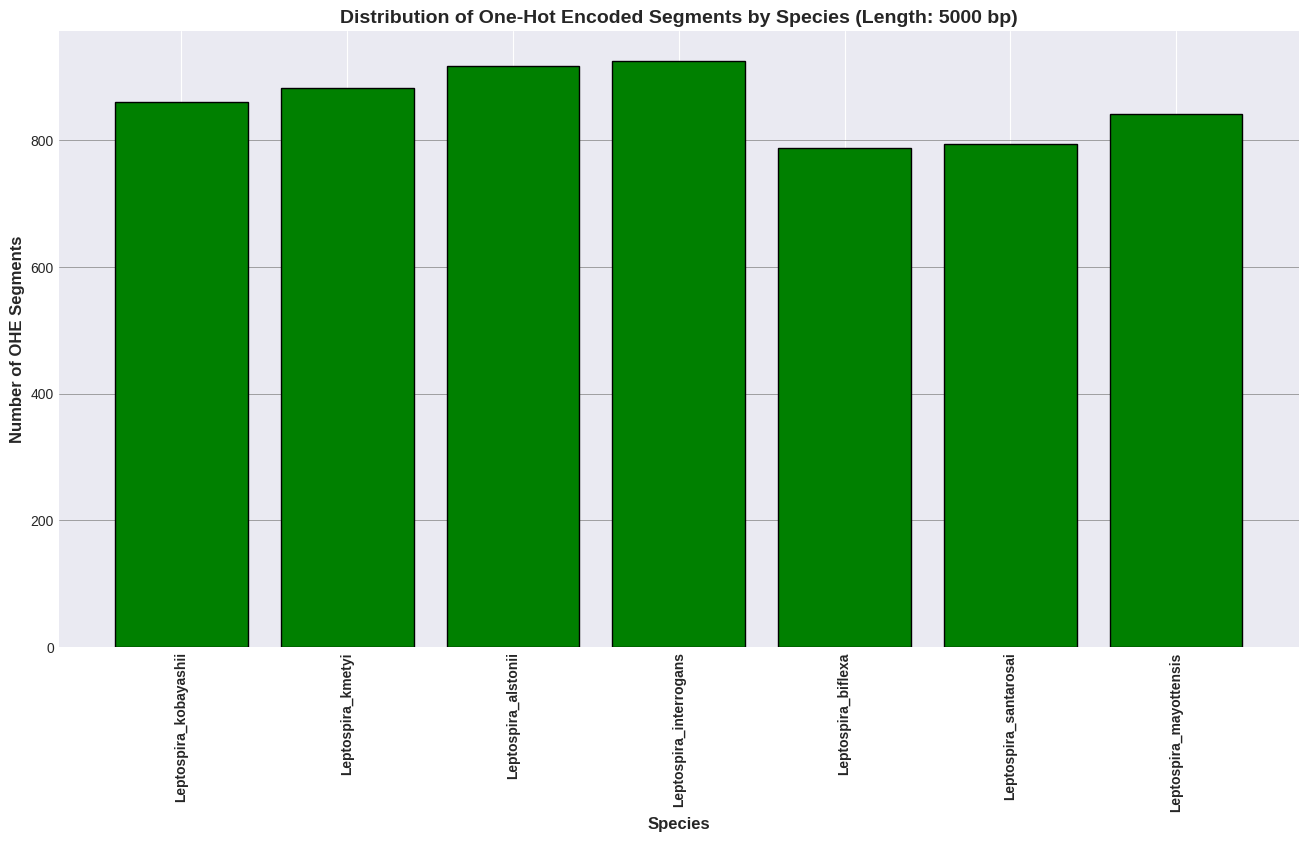

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Dictionary of Encoded Segment Distribution:


{'Leptospira_kobayashii': 860,
 'Leptospira_kmetyi': 882,
 'Leptospira_alstonii': 918,
 'Leptospira_interrogans': 926,
 'Leptospira_biflexa': 788,
 'Leptospira_santarosai': 795,
 'Leptospira_mayottensis': 842}

In [69]:
# ----------------------------------------------------
# 9. Visualize One-Hot Encoded Segment Distribution
# This section generates a bar chart to visualize the
# number of One-Hot Encoded segments generated for each
# species, providing an overview of the dataset balance.
# ----------------------------------------------------

# Assuming 'segment_distribution_by_species' dictionary is available from the previous cell

# Extract data for plotting from the 'segment_distribution' dictionary
segment_counts = list(segment_distribution_by_species.values())
species_labels = list(segment_distribution_by_species.keys())

# Define figure size for better readability, especially with many species
# Adjust figsize as needed based on the number of species for optimal visualization
plt.figure(figsize=(16, 8)) # Increased figure size for clarity

# Create the bar chart
plt.bar(species_labels, segment_counts, edgecolor="black", color="green", zorder=3)

# Set X-axis ticks and labels
plt.xticks(rotation=90, fontweight="bold", fontsize=10) # Apply rotation and font settings

# Add labels and title to the plot
plt.xlabel("Species", fontweight="bold", fontsize=12) # X-axis label
plt.ylabel("Number of OHE Segments", fontweight="bold", fontsize=12) # Y-axis label
plt.title(f"Distribution of One-Hot Encoded Segments by Species (Length: {max_len} bp)",
          fontweight="bold", fontsize=14) # Dynamic title including segment length

# Add grid lines for better readability
plt.grid(True, axis='y', color='grey', linestyle='-', linewidth=0.5, zorder=0) # zorder=0 places grid behind bars

# Use current date and time in Venezuela timezone for filename
venezuela_tz = pytz.timezone("America/Caracas")
current_datetime_vz = datetime.datetime.now(venezuela_tz)
timestamp_str = current_datetime_vz.strftime("%d-%m-%Y_%H-%M-%S") # Add the time to the file name

# Define the filename to save the plot
file_name = f"OHE_Segment_Distribution_Length_{max_len}bp_{timestamp_str}.png"

# Save the plot
plt.savefig(file_name, dpi=600, bbox_inches='tight') # dpi=600 for high resolution, bbox_inches='tight' prevents labels from being cut off

# Display the plot in the notebook
plt.show()

# Download the file automatically
files.download(file_name)

# Display the dictionary used for plotting (as requested by your original cell)
# Using 'segment_distribution' as created in the previous recommended cell.
print("\nDictionary of Encoded Segment Distribution:")
display(segment_distribution_by_species)

In [70]:
# ----------------------------------------------------
# 10. Dataset Preparation: Feature (X) and Label (y) Arrays
# This section prepares the final dataset for model training.
# It flattens all One-Hot Encoded genomic segments into a single
# feature array (X) and creates corresponding numerical labels (y)
# by mapping species names to unique integer indices.
# ----------------------------------------------------

# Transform the dictionary to a dataset
X = []
y = []

# Create a dictionary to map species to indices
species_to_index = {}

for species, n_species in zip(sorted(species_sequences_dict.keys()), range(0, total_species_count)):
  species_to_index[species] = n_species

# Populate X and y lists
for species, sequences in encoded_sequences.items():
    for sequence in sequences:
        X.append(sequence)
        y.append(species_to_index[species])

# Convert lists to arrays
X = np.array(X)
y = np.array(y)

num_classes = total_species_count

print(species_to_index)

{'Leptospira_alstonii': 0, 'Leptospira_biflexa': 1, 'Leptospira_interrogans': 2, 'Leptospira_kmetyi': 3, 'Leptospira_kobayashii': 4, 'Leptospira_mayottensis': 5, 'Leptospira_santarosai': 6}


In [71]:
# ----------------------------------------------------
# 11. One-Hot Encode Labels for Model Compatibility
# This section transforms the numerical class labels (y)
# into a One-Hot Encoded format, which is required for
# training a multi-class classification model in Keras.
# ----------------------------------------------------

# Convert numerical labels (y) into a One-Hot Encoded format.
y = tf.keras.utils.to_categorical(y, num_classes=num_classes)

print("--- Labels One-Hot Encoding Complete ---")

--- Labels One-Hot Encoding Complete ---


In [72]:
# ----------------------------------------------------
# 12. Dataset Splitting: Training and Testing Sets
# This section divides the prepared feature (X) and label (y)
# datasets into training and testing subsets. A fixed random state
# ensures reproducibility, and stratification maintains class
# distribution across subsets.
# ----------------------------------------------------

# Divide the dataset into training and testing sets
# X: Feature data (One-Hot Encoded genomic segments)
# y: Label data (One-Hot Encoded species labels)
# test_size=0.2: Allocates 20% of the data to the test set, 80% to the training set.
# shuffle=True: Shuffles the data before splitting, preventing order-dependent issues.
# stratify=y: Ensures that the proportion of samples for each class is the same
#             in both the training and testing sets as in the complete dataset.
# random_state=42: Sets a seed for random number generation, making the split
#                  reproducible.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, stratify = y, random_state = 42)

# Print the shapes of the resulting datasets to verify the split
print(f"Shape of X (total features): {X.shape}")
print(f"Shape of y (total labels): {y.shape}")
print(f"Shape of X_train (training features): {X_train.shape}")
print(f"Shape of y_train (training labels): {y_train.shape}")
print(f"Shape of X_test (testing features): {X_test.shape}")
print(f"Shape of y_test (testing labels): {y_test.shape}")

print("\nDataset splitting complete.")


Shape of X (total features): (6011, 5000, 4)
Shape of y (total labels): (6011, 7)
Shape of X_train (training features): (4808, 5000, 4)
Shape of y_train (training labels): (4808, 7)
Shape of X_test (testing features): (1203, 5000, 4)
Shape of y_test (testing labels): (1203, 7)

Dataset splitting complete.


In [73]:
# ----------------------------------------------------
# 13. Convolutional Neural Network (CNN) Model Definition
# This section defines the architecture of the 1D CNN model
# using Keras's Sequential. The model is designed for
# multi-class classification of genomic sequences.
# ----------------------------------------------------

print("--- Defining the CNN Model Architecture ---")

# Define the CNN model using Sequential
model = Sequential([
    # First Convolutional Layer (Conv1D)
    # filters: Number of convolution filters (feature maps).
    # kernel_size: Length of the 1D convolution window (filter size).
    # input_shape: Defines the shape of the input data (segments), derived from X_train.
    #              X_train.shape[1] is the sequence length (e.g., 5000).
    #              X_train.shape[2] is the number of features per nucleotide (e.g., 4 for OHE A,C,G,T).
    # activation='relu': Rectified Linear Unit, a common activation function for hidden layers.
    # kernel_regularizer: L1 regularization applied to the convolution kernel weights
    #                     to help prevent overfitting by penalizing large weights.
    Conv1D(filters=300,
           kernel_size=12,
           input_shape=(X_train.shape[1], X_train.shape[2]),
           activation='relu',
           kernel_regularizer=regularizers.l1(l1=0.000005)),

    # First Pooling Layer (MaxPooling1D)
    # pool_size: Downsamples the input by taking the maximum value over a window.
    #            Reduces dimensionality and extracts dominant features.
    MaxPooling1D(pool_size=8),

    # Second Convolutional Layer (Conv1D)
    # filters: Number of convolution filters.
    # kernel_size: Length of the 1D convolution window.
    # activation='relu': Rectified Linear Unit.
    # kernel_regularizer: L1 regularization to penalize weights.
    Conv1D(filters=300,
           kernel_size=24,
           activation='relu',
           kernel_regularizer=regularizers.l1(l1=0.000005)),

    # Global Average Pooling Layer (GlobalAveragePooling1D)
    # Computes the average of the output of the previous layer across all time steps (spatial dimensions).
    # Reduces each feature map to a single value.
    GlobalAveragePooling1D(),

    # Output Dense Layer
    # units=num_classes: Number of neurons equals the number of unique species classes.
    # activation='softmax': Softmax activation function, outputs a probability distribution
    #                       over the 'num_classes' classes, suitable for multi-class classification.
    Dense(num_classes, activation='softmax')
])

print("\n--- Model Architecture Summary ---")
# Display a summary of the model architecture
model.summary()

print("\nCNN model definition complete. Proceed to model compilation and training.")

--- Defining the CNN Model Architecture ---

--- Model Architecture Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 4989, 300)      │        14,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 623, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 600, 300)       │     2,160,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         2,107 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,177,107 (8.31 MB)

 Trainable params: 2,177,107 (8.31 MB)

 Non-trainable params: 0 (0.00 B)


CNN model definition complete. Proceed to model compilation and training.


In [74]:
# ----------------------------------------------------
# 14. Visualize CNN Model Architecture
# This section generates a visual representation of the
# defined Convolutional Neural Network (CNN) model's architecture.
# The plot includes layer types, shapes, and names, and is saved
# as an image file for documentation and later review.
# ----------------------------------------------------

print("--- Generating CNN Model Architecture Plot ---")

# Obtain the current date and time in Venezuela timezone for the filename
venezuela_tz = pytz.timezone('America/Caracas')
current_datetime_vz = datetime.datetime.now(venezuela_tz)
# Use DD-MM-YYY_HH-MM-SS format
timestamp_str = current_datetime_vz.strftime("%d-%m-%Y_%H-%M-%S")

# Define the filename for the model architecture plot
# Include segment length (max_len) for better identification, if available from earlier cells
model_plot_filename = f"cnn_model_architecture_length_{max_len}bp_{timestamp_str}.png" # filename

# Generate the plot of the model
tf.keras.utils.plot_model(
    model,
    to_file=model_plot_filename,
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=600
)

print(f"\nModel architecture plot saved as: {model_plot_filename}")

# Download the file automatically to your local machine
print("\nInitiating automatic download of the model architecture plot...")
files.download(model_plot_filename)


--- Generating CNN Model Architecture Plot ---

Model architecture plot saved as: cnn_model_architecture_length_5000bp_25-07-2025_02-24-05.png

Initiating automatic download of the model architecture plot...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [75]:
# ----------------------------------------------------
# 15. Model Compilation, Training, and Evaluation
# This section defines the optimizer, compiles the CNN model,
# sets up training callbacks (Early Stopping, Model Checkpoint),
# trains the model using the prepared datasets, and finally evaluates
# its performance on the test set.
# ----------------------------------------------------

print("--- Configuring Model Compilation and Training ---")

# --- Optimizers Definition ---
# Define different optimizers that could be used.
# Only one will be selected for model compilation.
optimizer_AdamW = tf.keras.optimizers.AdamW(learning_rate=0.001)
optimizer_Adam = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer_SGD = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# --- Model Compilation ---
# Compile the defined CNN model.
# optimizer: Specifies the optimization algorithm to adjust model weights (e.g., Adam).
# loss: The loss function to minimize during training. 'categorical_crossentropy' is
#       appropriate for multi-class classification.
# metrics: A list of metrics to monitor during training and evaluation (e.g., 'accuracy').

model.compile(optimizer=optimizer_Adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\nModel compiled successfully.")

# --- Callbacks Definition ---
# Callbacks are functions that can be applied at certain stages of the training process.

# Define a dynamic path for saving checkpoints, including segment length.
# Using a temporary directory that will be managed by Colab, or a specified one.
checkpoint_dir = "/tmp/cnn_checkpoints" # Temporary directory for checkpoints
tf.io.gfile.makedirs(checkpoint_dir) # Ensure the directory exists
checkpoint_filepath = f"{checkpoint_dir}/best_model_length_{max_len}bp.keras" # filename

# EarlyStopping: Stops training if a monitored metric stops improving.
# monitor='val_accuracy': Metric to monitor (validation accuracy).
# mode='max': Training stops when the monitored metric (val_accuracy) stops increasing.
# patience=20: Number of epochs with no improvement after which training will be stopped.
# restore_best_weights=True: Restores model weights from the epoch with the best monitored value.

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=20,
    restore_best_weights=True,
    verbose=1 # Display messages when stopping
)

# ModelCheckpoint: Saves the best model weights during training.
# filepath: Path where the model will be saved.
# monitor='val_accuracy': Metric to monitor for saving the best model.
# save_best_only=True: Only the model with the best 'val_accuracy' will be saved.
# verbose=0: No messages will be printed when a model is saved. Change to 1 for updates.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_accuracy",
    verbose=1, # Changed to 1 to see saving updates
    save_best_only=True
)

print(f"\nModel checkpoints will be saved to: {checkpoint_filepath}")

# --- Model Training ---
# Train the defined CNN model using the prepared training and validation data.
BATCH_SIZE = 32 # Number of samples per gradient update
NUM_EPOCHS = 200 # Number of complete passes through the training dataset

print(f"\n--- Starting Model Training (Epochs: {NUM_EPOCHS}, Batch Size: {BATCH_SIZE}) ---")

# Train the model
# x: Training feature data (X_train).
# y: Training label data (y_train).
# epochs: Number of training iterations over the entire dataset.
# batch_size: Number of samples processed before the model's parameters are updated.
# validation_data: Tuple of (X_test, y_test) used to evaluate the model at the end of each epoch.
# callbacks: List of functions to be applied during training (e.g., EarlyStopping, ModelCheckpoint).
# steps_per_epoch: Total number of steps (batches of samples) before a training epoch is considered finished.
# validation_steps: Total number of steps (batches of samples) to draw before a validation round is finished.

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[model_checkpoint_callback],
    steps_per_epoch=int(np.ceil(len(X_train) / float(BATCH_SIZE))),
    validation_steps=int(np.ceil(len(X_test) / float(BATCH_SIZE)))
)

print("\nModel training complete.")

# ---  Model Evaluation ---
# Evaluate the trained model's performance on the test dataset.
print("\n--- Evaluating Model Performance on Test Set ---")
evaluation_results = model.evaluate(X_test, y_test, verbose=0) # Set verbose to 0 to suppress per-batch output

# Extract accuracy from evaluation results (accuracy is at index 1 as per model.compile metrics)
test_loss = evaluation_results[0]
test_accuracy = evaluation_results[1]

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

print("\nModel evaluation complete.")

--- Configuring Model Compilation and Training ---

Model compiled successfully.

Model checkpoints will be saved to: /tmp/cnn_checkpoints/best_model_length_5000bp.keras

--- Starting Model Training (Epochs: 3, Batch Size: 32) ---


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/3
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2173 - loss: 2.0684
Epoch 1: val_accuracy improved from -inf to 0.44722, saving model to /tmp/cnn_checkpoints/best_model_length_5000bp.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1083s 7s/step - accuracy: 0.2178 - loss: 2.0670 - val_accuracy: 0.4472 - val_loss: 1.4752
Epoch 2/3
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4250 - loss: 1.4736
Epoch 2: val_accuracy did not improve from 0.44722
151/151 ━━━━━━━━━━━━━━━━━━━━ 1051s 7s/step - accuracy: 0.4252 - loss: 1.4733 - val_accuracy: 0.3915 - val_loss: 1.4918
Epoch 3/3
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5148 - loss: 1.3059
Epoch 3: val_accuracy improved from 0.44722 to 0.65337, saving model to /tmp/cnn_checkpoints/best_model_length_5000bp.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1098s 7s/step - accuracy: 0.5151 - loss: 1.3052 - val_accuracy: 0.6534 - val_loss: 1.0321

Model training complete.

--- Evaluating Model Performance on Test Set ---
Test Loss: 1.0321
T

In [76]:
# ----------------------------------------------------
# 16. Load Best Model Version and evaluate Performance
# This section loads the model with the best validation accuracy
# saved during the training process via the ModelCheckpoint callback.
# The loaded model is then evaluated on the test set to confirm
# its final performance.
# ----------------------------------------------------

# Assuming 'checkpoint_filepath' is available from the training cell.
# This filepath points to the model saved by ModelCheckpoint with the best validation accuracy.
print(f"--- Loading the best version of the model from: {checkpoint_filepath} ---")

# Load the best model saved during training
try:
    best_model = keras.models.load_model(checkpoint_filepath)
    print("\nBest model loaded successfully.")
except Exception as e:
    print(f"Error loading model from {checkpoint_filepath}: {e}")
    print("Please ensure the training cell was executed successfully and a model was saved.")
    best_model = model # Fallback to the last trained model if checkpoint fails (not ideal)

# Evaluate the loaded best model on the test dataset
print("\n--- Evaluating the best model on the test set ---")
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=2)

# Print the evaluation results
print(f'\nLoaded model Test Loss: {test_loss:.4f}') # Format loss to 4 decimal places
print(f'Loaded model Test Accuracy: {test_accuracy*100:.2f}%') # Format accuracy as percentage

--- Loading the best version of the model from: /tmp/cnn_checkpoints/best_model_length_5000bp.keras ---

Best model loaded successfully.

--- Evaluating the best model on the test set ---
38/38 - 70s - 2s/step - accuracy: 0.6534 - loss: 1.0321

Loaded model Test Loss: 1.0321
Loaded model Test Accuracy: 65.34%


In [79]:
# ----------------------------------------------------
# 17. Save Training History Data to CSV
# This section extracts the training and validation metrics
# (loss and accuracy) from the 'history' object, organizes
# them into a pandas DataFrame, saves this data to a CSV file
# with a timestamp, and then automatically downloads the file.
# This ensures that the training progression is recorded for
# further analysis or reporting.
# ----------------------------------------------------

print("--- Saving Training History Data to CSV ---")

# Obtain the current date and time in Venezuela timezone for the filename
venezuela_tz = pytz.timezone('America/Caracas')
now = datetime.datetime.now(venezuela_tz)
timestamp = now.strftime("%d-%m-%Y_%H-%M-%S")

# Create a dictionary with the training history data
# 'history' object is assumed to be available from the model training step.
training_history_data = {
    'epoch': history.epoch,
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy']
}

# Create a pandas DataFrame from the history data
history_df = pd.DataFrame(training_history_data)

# Define the CSV filename, including a timestamp and segment length
csv_file_path = f"training_history_length_{max_len}bp_{timestamp}.csv"

# Save the DataFrame to a CSV file
# index=False prevents pandas from writing the DataFrame index as a column in the CSV.
history_df.to_csv(csv_file_path, index=False)

print(f"\nTraining history data saved to: {csv_file_path} (Venezuela Time)")

# Download the file automatically to your local machine
print(f"Initiating automatic download of: {csv_file_path}")
files.download(csv_file_path)
print("Download request sent.")


--- Saving Training History Data to CSV ---

Training history data saved to: training_history_length_5000bp_25-07-2025_03-22-50.csv (Venezuela Time)
Initiating automatic download of: training_history_length_5000bp_25-07-2025_03-22-50.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download request sent.


--- Plotting Training History (Loss and Accuracy) ---


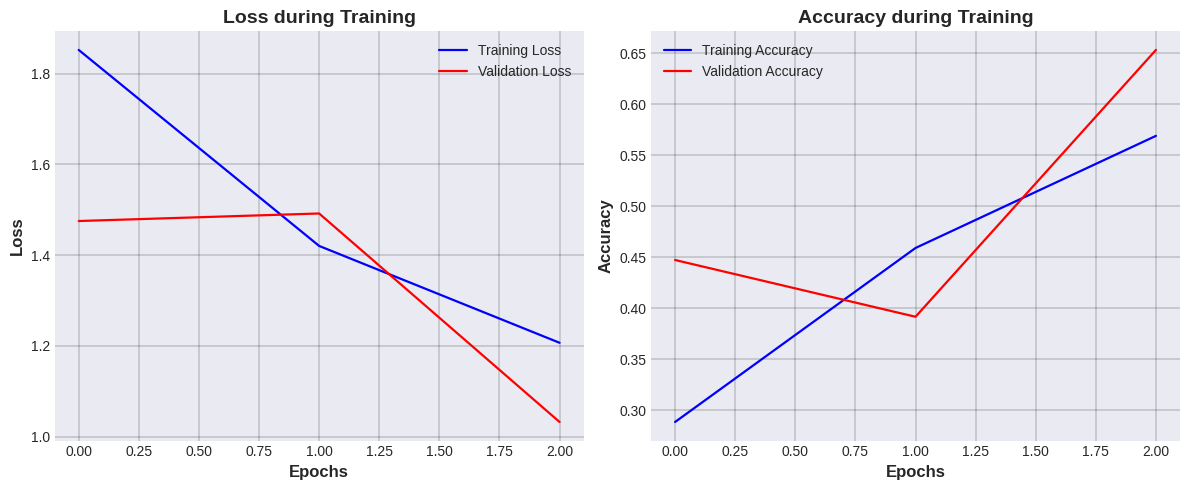


Initiating automatic download of the plot: training_performance_length_5000bp_25-23-2025_03-23-01.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download request sent.


In [80]:
# ----------------------------------------------------
# 18. Visualize Model Training History
# This section plots the training and validation loss,
# as well as training and validation accuracy over epochs.
# This visualization is crucial for monitoring model performance,
# identifying overfitting/underfitting, and assessing convergence.
# ----------------------------------------------------

print("--- Plotting Training History (Loss and Accuracy) ---")

# Set a plotting style
# 'seaborn-v0_8-darkgrid' provides a dark grid background, useful for clarity.
plt.style.use('seaborn-v0_8-darkgrid')

# Configure the figure size for the subplots
plt.figure(figsize=(12, 5)) # Adjusted figure size for better aspect ratio

# --- Subplot 1: Loss during Training ---
plt.subplot(1, 2, 1) # (rows, columns, plot_number)

# Plot training and validation loss with custom colors and linewidth
plt.plot(history.epoch, history.history["loss"],
         color='blue', label='Training Loss', linewidth=1.6)
plt.plot(history.epoch, history.history["val_loss"],
         color='red', label='Validation Loss', linewidth=1.6)

# Add grid lines for readability
plt.grid(color='black', linewidth=0.2, linestyle='-')

# Add titles and labels
plt.title('Loss during Training', weight='bold', fontsize=14)
plt.xlabel('Epochs', weight='bold', fontsize=12)
plt.ylabel('Loss', weight='bold', fontsize=12)
plt.legend(fontsize=10) # Adjust legend font size

# --- Subplot 2: Accuracy during Training ---
plt.subplot(1, 2, 2) # (rows, columns, plot_number)

# Plot training and validation accuracy with custom colors and linewidth
plt.plot(history.epoch, history.history["accuracy"],
         color='blue', label='Training Accuracy', linewidth=1.6)
plt.plot(history.epoch, history.history["val_accuracy"],
         color='red', label='Validation Accuracy', linewidth=1.6)

# Add grid lines for readability
plt.grid(color='black', linewidth=0.2, linestyle='-')
plt.legend(fontsize=10) # Adjust legend font size

# Add titles and labels
plt.title('Accuracy during Training', weight='bold', fontsize=14)
plt.xlabel('Epochs', weight='bold', fontsize=12)
plt.ylabel('Accuracy', weight='bold', fontsize=12)


# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# --- Save and Show Plot ---
# Obtain the current date and time in Venezuela timezone for the filename
venezuela_tz = pytz.timezone('America/Caracas')
current_datetime_vz = datetime.datetime.now(venezuela_tz)
# Use format for time
timestamp_str = current_datetime_vz.strftime("%d-%M-%Y_%H-%M-%S")

# Define a descriptive filename including segment length and timestamp
plot_filename = f"training_performance_length_{max_len}bp_{timestamp_str}.png"

# Save the plot with high resolution
plt.savefig(plot_filename, dpi=600, bbox_inches='tight') # bbox_inches='tight' prevents labels from being cut off

# Display the plot in the notebook output
plt.show()

# Download the file automatically to your local machine
print(f"\nInitiating automatic download of the plot: {plot_filename}")
files.download(plot_filename)
print("Download request sent.")


--- Generating Confusion Matrix ---
38/38 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step

Normalized Confusion Matrix calculated.


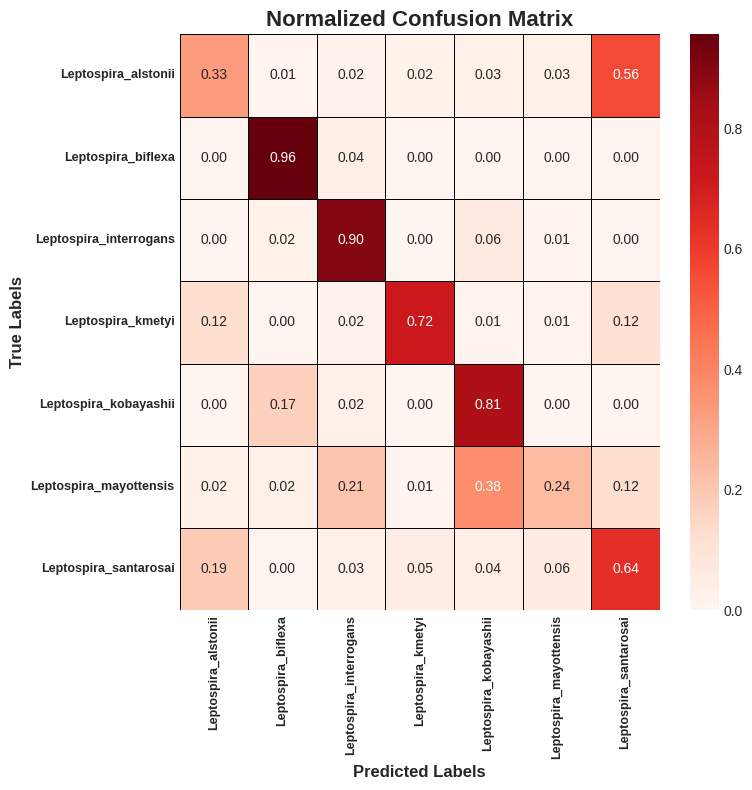


--- Species to Index Mapping (Legend) ---
  0: Leptospira_alstonii
  1: Leptospira_biflexa
  2: Leptospira_interrogans
  3: Leptospira_kmetyi
  4: Leptospira_kobayashii
  5: Leptospira_mayottensis
  6: Leptospira_santarosai

Initiating automatic download of: normalized_confusion_matrix_length_5000bp_25-07-2025_03-24-36.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download request sent.


In [81]:
# ----------------------------------------------------
# 19. Confusion Matrix Generation and Visualization
# This section generates a confusion matrix for the model's
# predictions on the test set, normalizes it, and visualizes
# it as a heatmap.
# ----------------------------------------------------

print("--- Generating Confusion Matrix ---")

# Get model predictions on the test set
# The 'predict' method returns probabilities for each class.
y_predictions_probabilities = best_model.predict(X_test)

# Convert predicted probabilities and true one-hot labels to class indices
# For softmax output, argmax(axis=1) directly gives the predicted class index.
# For one-hot encoded true labels, argmax(axis=1) also gives the true class index.
y_predicted_classes = np.argmax(y_predictions_probabilities, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the Confusion Matrix
# cm[i][j] represents the number of samples known to be in class i and predicted to be in class j.
cm = confusion_matrix(y_true_classes, y_predicted_classes)

# Normalize the Confusion Matrix
# Normalize by true labels (rows): cm_normalized[i][j] is the percentage of
# class i samples that were predicted as class j.
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print("\nNormalized Confusion Matrix calculated.")

# Visualize the Normalized Confusion Matrix as a Heatmap
# Determine the number of classes for proper axis labeling
num_classes = len(species_to_index)
# Get sorted species names to match the order of indices used in the matrix
sorted_species_names = sorted(species_to_index.keys(), key=species_to_index.get)

# Adjust figure size based on the number of classes for better readability
# A larger figure might be needed for many species.
fig_size = max(8, num_classes * 0.6) # Dynamic size, adjust multiplier as needed
plt.figure(figsize=(fig_size, fig_size))

sns.heatmap(cm_normalized,
            annot=True,     # Show the numerical values in the cells
            cmap='Reds',    # Colormap (e.g., 'Reds', 'Blues', 'viridis')
            fmt=".2f",      # Format numerical values to 2 decimal places
            linewidths=.5,  # Add lines between cells for clarity
            linecolor='black' # Color of lines between cells
           )

# Set the labels for the x and y-axis ticks to be the species names
plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=sorted_species_names, rotation=90, ha='center', fontsize=9, weight='bold')
plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=sorted_species_names, rotation=0, va='center', fontsize=9, weight='bold')

# Add titles and labels
plt.title('Normalized Confusion Matrix', weight='bold', fontsize=16)
plt.xlabel('Predicted Labels', weight='bold', fontsize=12)
plt.ylabel('True Labels', weight='bold', fontsize=12)

plt.tight_layout() # Adjust layout to prevent labels from overlapping

# 6. Save and Display the Plot
# Obtain current date and time in Venezuela timezone for filename
venezuela_tz = pytz.timezone('America/Caracas')
current_datetime_vz = datetime.datetime.now(venezuela_tz)
timestamp_str = current_datetime_vz.strftime("%d-%m-%Y_%H-%M-%S")

# Define a descriptive filename including segment length for context
# Assuming 'max_len' is available from earlier cells.
plot_filename = f"normalized_confusion_matrix_length_{max_len}bp_{timestamp_str}.png"

plt.savefig(plot_filename, dpi=600, bbox_inches='tight') # Save with high resolution, prevent cutoff
plt.show()

# 7. Print Legend (Species to Index Mapping)
print('\n--- Species to Index Mapping (Legend) ---')
# Iterate through the sorted species_to_index mapping for clear legend
for species_name, index in sorted(species_to_index.items(), key=lambda item: item[1]):
    print(f"  {index}: {species_name}")

# 8. Download the file automatically
print(f"\nInitiating automatic download of: {plot_filename}")
files.download(plot_filename)
print("Download request sent.")

--- Generating Raw Confusion Matrix ---
38/38 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step

Raw Confusion Matrix (Counts):

[[ 61   1   3   4   6   6 103]
 [  0 151   7   0   0   0   0]
 [  0   4 167   0  12   2   0]
 [ 22   0   3 127   2   2  21]
 [  0  29   4   0 139   0   0]
 [  4   4  35   1  63  40  21]
 [ 30   0   4   8   7   9 101]]


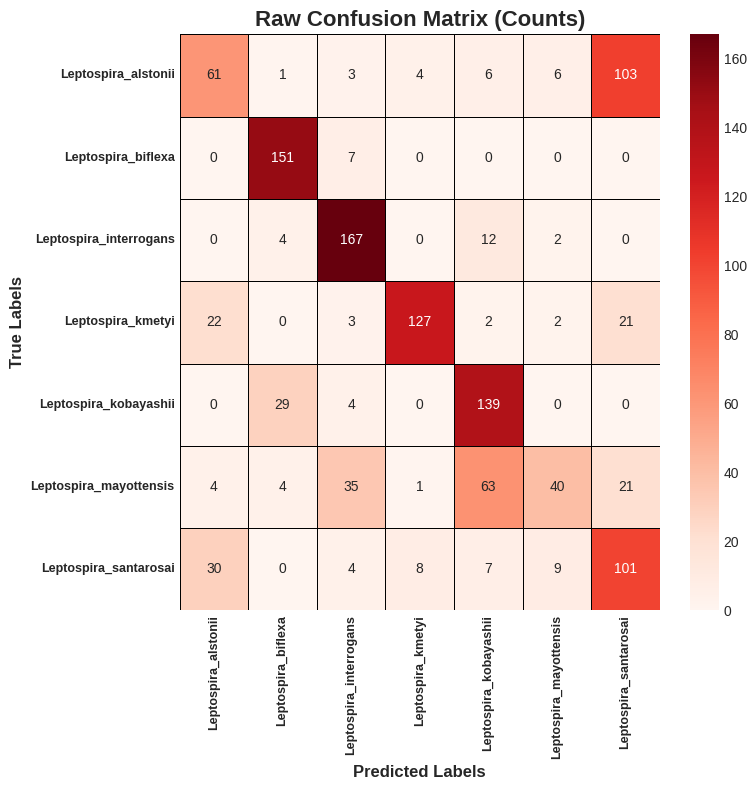


--- Species to Index Mapping (Legend) ---
  0: Leptospira_alstonii
  1: Leptospira_biflexa
  2: Leptospira_interrogans
  3: Leptospira_kmetyi
  4: Leptospira_kobayashii
  5: Leptospira_mayottensis
  6: Leptospira_santarosai

Initiating automatic download of: raw_confusion_matrix_length_5000bp_25-07-2025_03-30-08.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download request sent.


In [82]:
# ----------------------------------------------------
# 20. Raw Confusion Matrix Generation and Visualization
# This section generates a confusion matrix showing the
# absolute counts of correct and incorrect predictions on the
# test set, visualizes it as a heatmap, and provides a legend
# mapping class indices to species names.
# ----------------------------------------------------

print("--- Generating Raw Confusion Matrix ---")

# Get model predictions on the test set
# The 'predict' method returns probabilities for each class.
y_predictions_probabilities = best_model.predict(X_test)

# Convert predicted probabilities and true one-hot labels to class indices
# np.argmax(axis=1) is used to get the index of the highest probability/true class.
y_predicted_classes = np.argmax(y_predictions_probabilities, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the Raw Confusion Matrix
# cm[i][j] represents the absolute number of samples that are truly in class i
# and were predicted by the model to be in class j.
raw_cm = confusion_matrix(y_true_classes, y_predicted_classes)

print('\nRaw Confusion Matrix (Counts):\n')
print(raw_cm) # Display the raw confusion matrix as text

# Visualize the Raw Confusion Matrix as a Heatmap
# Determine the number of classes for proper axis labeling
num_classes = len(species_to_index)
# Get sorted species names to match the order of indices used in the matrix
sorted_species_names = sorted(species_to_index.keys(), key=species_to_index.get)

# Adjust figure size dynamically based on the number of classes
fig_size = max(8, num_classes * 0.6) # Adjust multiplier as needed for optimal size
plt.figure(figsize=(fig_size, fig_size))

sns.heatmap(raw_cm,
            annot=True,     # Show the numerical values in the cells
            cmap='Reds',    # Colormap (e.g., 'Reds', 'Blues', 'viridis')
            fmt=".0f",      # Format numerical values as integers (raw counts)
            linewidths=.5,  # Add lines between cells for clarity
            linecolor='black' # Color of lines between cells
           )

# Set the labels for the x and y-axis ticks to be the species names
plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=sorted_species_names, rotation=90, ha='center', fontsize=9, weight='bold')
plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=sorted_species_names, rotation=0, va='center', fontsize=9, weight='bold')

# Add titles and labels
plt.title('Raw Confusion Matrix (Counts)', weight='bold', fontsize=16)
plt.xlabel('Predicted Labels', weight='bold', fontsize=12)
plt.ylabel('True Labels', weight='bold', fontsize=12)

plt.tight_layout() # Adjust layout to prevent labels from overlapping

# Save and Display the Plot
# Obtain current date and time in Venezuela timezone for filename consistency
venezuela_tz = pytz.timezone('America/Caracas')
current_datetime_vz = datetime.datetime.now(venezuela_tz)
timestamp_str = current_datetime_vz.strftime("%d-%m-%Y_%H-%M-%S")

# Define a descriptive filename including segment length and timestamp
plot_filename = f"raw_confusion_matrix_length_{max_len}bp_{timestamp_str}.png"

plt.savefig(plot_filename, dpi=600, bbox_inches='tight') # Save with high resolution
plt.show()

# Print Legend (Species to Index Mapping)
print('\n--- Species to Index Mapping (Legend) ---')
# Iterate through the sorted species_to_index mapping for clear legend
for species_name, index in sorted(species_to_index.items(), key=lambda item: item[1]):
    print(f"  {index}: {species_name}")

# Download the file automatically
print(f"\nInitiating automatic download of: {plot_filename}")
files.download(plot_filename)
print("Download request sent.")

In [ ]:
# ----------------------------------------------------
# 21. Save Trained Model
# This final section saves the best performing CNN model
# (identified during training by the ModelCheckpoint callback)
# to a '.keras' file. The filename includes a timestamp and
# the genomic segment length for easy identification.
# The saved model can then be reloaded for inference or deployment.
# ----------------------------------------------------
import tensorflow as tf # Ensure TensorFlow is imported
from tensorflow import keras # Ensure keras is imported
import datetime # Ensure datetime is imported
import pytz # Ensure pytz is imported
from google.colab import files # Ensure files is imported

print("--- Saving the Best Trained Model ---")

# Obtain the current date and time in Venezuela timezone for the filename
venezuela_tz = pytz.timezone('America/Caracas')
now = datetime.datetime.now(venezuela_tz)
timestamp = now.strftime("%Y-%m-%d_%H-%M-%S") # Use YYYY-MM-DD_HH-MM-SS for better sorting

# Define the filename for saving the model.
# It's highly recommended to include 'max_len' in the filename
# to easily identify the model's configuration based on segment length.
# Assuming 'max_len' is available from earlier cells.
model_filename = f"cnn_leptospira_model_length_{max_len}bp_{timestamp}.keras"

# Save the complete model (architecture, weights, optimizer state)
# 'best_model' is the instance loaded from the checkpoint, representing the
# model with the best validation accuracy during training.
try:
    best_model.save(model_filename)
    print(f"\nThe best trained model has been successfully saved to: {model_filename}")
except Exception as e:
    print(f"Error saving the model to {model_filename}: {e}")
    print("Please ensure 'best_model' is defined and the path is accessible.")


# Download the file automatically to your local machine
print(f"\nInitiating automatic download of the model file: {model_filename}")
files.download(model_filename)
print("Download request sent.")

print("\n--- Model Saving and Download Complete ---")
print("This marks the end of the main script. The saved model can be used for future predictions.")

In [83]:
# ----------------------------------------------------
# 23. Save Trained Model
# This final section saves the best performing CNN model
# to a '.keras' file. The filename includes a timestamp and
# the genomic segment length for easy identification.
# ----------------------------------------------------

print("--- Saving the Best Trained Model ---")

# Obtain the current date and time in Venezuela timezone for the filename
venezuela_tz = pytz.timezone('America/Caracas')
now = datetime.datetime.now(venezuela_tz)
timestamp = now.strftime("%d-%m-%Y_%H-%M-%S")

# Define the filename for saving the model.
model_filename = f"cnn_leptospira_model_length_{max_len}bp_{timestamp}.keras"

# Save the complete model (architecture, weights, optimizer state)
# 'best_model' is the instance loaded from the checkpoint, representing the
# model with the best validation accuracy during training.
try:
    best_model.save(model_filename)
    print(f"\nThe best trained model has been successfully saved to: {model_filename}")
except Exception as e:
    print(f"Error saving the model to {model_filename}: {e}")
    print("Please ensure 'best_model' is defined and the path is accessible.")

# Download the file automatically to your local machine
print(f"\nInitiating automatic download of the model file: {model_filename}")
files.download(model_filename)
print("Download request sent.")

print("\n--- Model Saving and Download Complete ---")

--- Saving the Best Trained Model ---

The best trained model has been successfully saved to: cnn_leptospira_model_length_5000bp_25-07-2025_03-37-01.keras

Initiating automatic download of the model file: cnn_leptospira_model_length_5000bp_25-07-2025_03-37-01.keras


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download request sent.

--- Model Saving and Download Complete ---
